# Selwyn Well l36_0477 Worked example (Slope... wait, no, Counterfactual Detection Power)

Before we get too far, lets import the necessary libraries and set up the notebook

In [15]:
from komanawa.gw_detect_power import DetectionPowerCounterFactual, AutoDetectionPowerCounterFactual
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from komanawa.kendall_stats import MannKendall
import datetime
from komanawa.gw_age_tools import check_age_inputs, predict_historical_source_conc, predict_future_conc_bepm
from scipy.interpolate import interp1d

## Background

Well l36_0477 is a 48m deep well located in the Selwyn district of Canterbury between Bankside and Rakaia near the north bank of the Rakaia River. There has been an historical increasing Nitrate concentration in this well and Environment Canterbury has completed age sampling which returned a mean residence time of 17.5 years.  This MRT was derived with an exponential piston flow model with an exponential fraction (f_p1) of 0.625.  A map of the well location is shown below.


![Well l36_0477 Location](figures/site_locationl36_0477.png "Well l36_0477 Location")


## Step 1 assess the historical data

The first thing to do is to visualise the historical NO$_{\text{3}}$-N data. Normally you would ingest this from a database, csv, or other data source.  For reproducibility, we have included the data as raw python input.

     n       date
0  2.8 1986-11-06
1  4.1 1987-11-18
2  2.4 1988-11-03
3  2.1 1989-10-03
4  1.7 1991-09-23


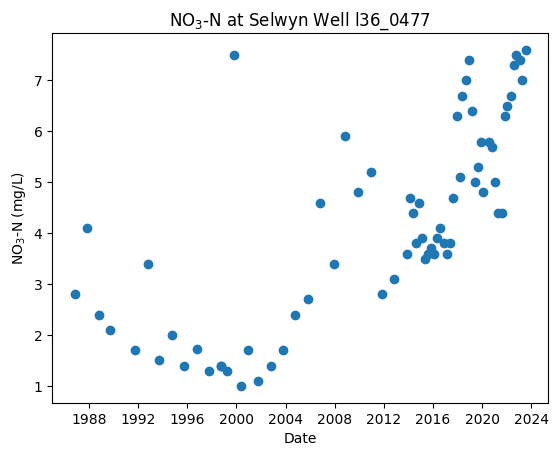

In [16]:
raw_n_vals = np.array([
    2.8, 4.1, 2.4, 2.1, 1.7, 3.4, 1.5, 2., 1.4, 1.73, 1.3,
    1.4, 1.4, 1.3, 7.5, 1., 1.7, 1.1, 1.4, 1.7, 2.4, 2.7, 4.6,
    3.4, 5.9, 4.8, 5.2, 2.8, 3.1, 3.6, 4.7, 4.4, 3.8, 4.6,
    3.9, 3.5, 3.6, 3.7, 3.6, 3.9, 4.1, 3.8, 3.6, 3.8, 4.7,
    6.3, 5.1, 6.7, 7., 7.4, 6.4, 5., 5.3, 5.8, 4.8, 5.8,
    5.7, 5., 4.4, 4.4, 6.3, 6.5, 6.7, 7.3, 7.5, 7.4, 7.,
    7.6])

raw_n_dates = np.array([
    '1986-11-06', '1987-11-18', '1988-11-03', '1989-10-03', '1991-09-23', '1992-10-12', '1993-09-28', '1994-09-28',
    '1995-10-02', '1996-10-14', '1997-10-06', '1998-09-30', '1998-09-30', '1999-04-07', '1999-10-12', '2000-05-12',
    '2000-11-29', '2001-10-11', '2002-10-22', '2003-10-16', '2004-10-19', '2005-10-26', '2006-10-25', '2007-12-13',
    '2008-11-12', '2009-11-10', '2010-12-13', '2011-11-14', '2012-10-30', '2013-11-19', '2014-02-07', '2014-05-07',
    '2014-08-04', '2014-11-05', '2015-02-05', '2015-05-04', '2015-08-03', '2015-11-05', '2016-02-02', '2016-05-04',
    '2016-08-04', '2016-11-08', '2017-02-23', '2017-05-23', '2017-08-24', '2017-11-28', '2018-02-27', '2018-05-17',
    '2018-08-29', '2018-11-22', '2019-02-26', '2019-05-30', '2019-08-20', '2019-11-22', '2020-01-28', '2020-07-21',
    '2020-10-28', '2021-01-14', '2021-04-15', '2021-07-28', '2021-10-26', '2022-01-19', '2022-04-20', '2022-07-28',
    '2022-10-14', '2023-01-26', '2023-04-04', '2023-07-12'])

ndata = pd.DataFrame({'n': raw_n_vals, 'date': pd.to_datetime(raw_n_dates)})

print(ndata.head())

fig, ax = plt.subplots()
ax.scatter(ndata['date'], ndata['n'])
ax.set_ylabel('NO$_{3}$-N (mg/L)')
ax.set_xlabel('Date')
ax.set_title('NO$_{3}$-N at Selwyn Well l36_0477')
pass

### Look and remove any outliers 
There is clearly some variability in the data and prior to 2000 there was clearly a decreasing trend.  However, there are some outliers that need to be removed. Identifying outliers is a topic in and of itself. For the purpose of this project we will simply remove the visual outlier of 7.5 mg/l in 2000.  (I know this is really an outlier because I added it as one to explain this point).  That outlier would really impact the variance of the data.

For the next step We will want to focus on the data after 2000, as we want to focus on any recent trend in the data. So for this purpose we will only keep the data after 2001.


In [17]:
ndata = ndata.loc[ndata.date > '2001-01-01'].set_index('date')

### Identify any historical trend

The next step it to identify and describe any historical trend in the data.  We will use a Mann Kendall test as it is non-parametric and does not require the data to be normally distributed.  

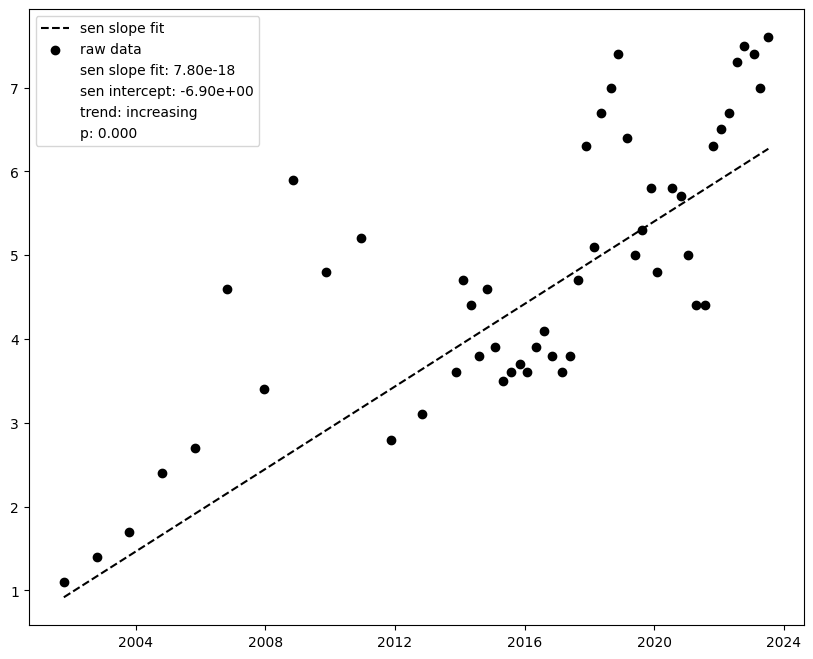

In [18]:
mk = MannKendall(ndata['n'], alpha=0.05)
mk.plot_data()
plt.show()

## Step 2: estimate the noise level

When it comes to estimating the variance of the data we can either use the standard deviation of the data or we can use the standard deviation of the residuals to a modelled value.  In this case we will use the standard deviation of the residuals to the sen slope and sen intercept from the Mann Kendall test.  This reduces the variance in the dataset as we are explaining much of the variation in the data with the trend.  More complicated models could be used, but for this example just accounting for the trend is sufficient.

The standard deviation of the data is:  1.64
The standard deviation of the residuals is:  1.06


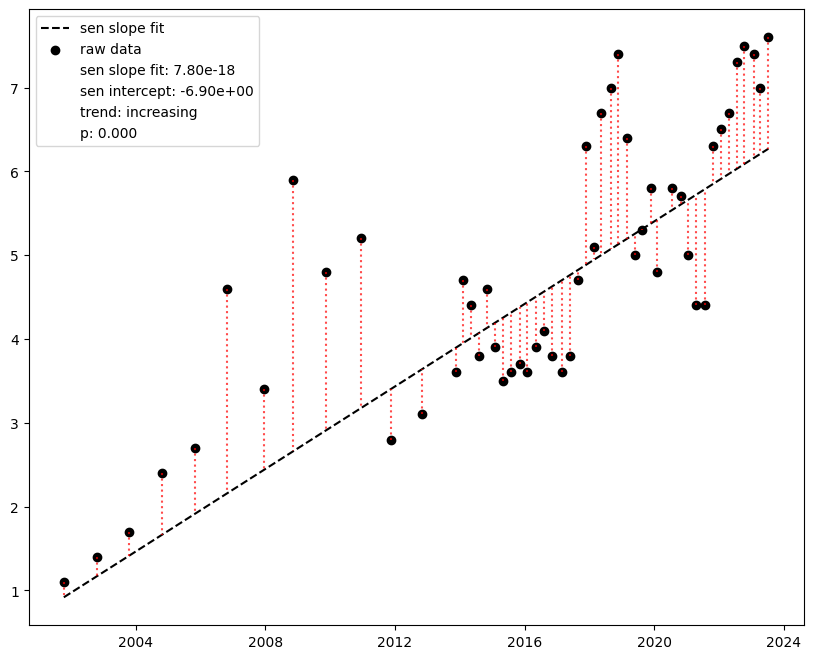

In [19]:
print('The standard deviation of the data is: ', round(ndata['n'].std(), 2))
senslope, senintercept, lo_slope, up_slope = mk.calc_senslope()
ndata['predicted'] = senslope * ndata.index.values.astype(float) + senintercept
ndata['residual'] = ndata['n'] - ndata['predicted']

input_error = ndata['residual'].std()

print('The standard deviation of the residuals is: ', round(input_error, 2))

fig, ax, (handles, labels) = mk.plot_data()
for i, row in ndata.iterrows():
    ax.plot([i, i], [row['n'], row['predicted']], color='red', ls=':', alpha=0.7)
plt.show()

## Step 3: Estimate the likely historical source concentration

We know that well l36_0477 has lag, and that lag is best described via an exponential piston flow model. All of our possible scenarios involve reductions to the average concentration in the source area of well l36_0477. Unfortunately, the source zone and the relative contributions of different land uses in that source zone is unknown.  Therefore, we need to estimate the likely historical source concentration.  We can do this as follows:


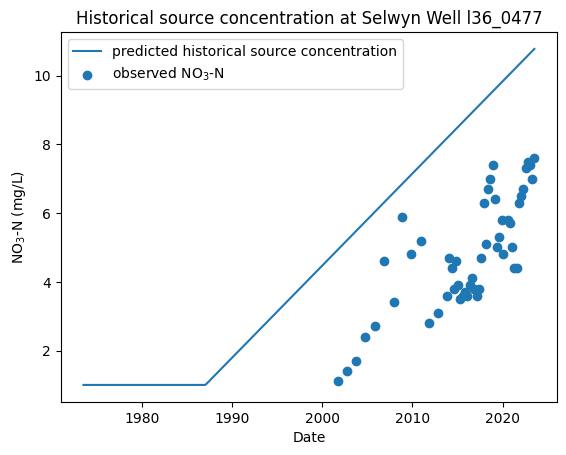

In [20]:
mrt = 17.5
mrt_p1 = 17.5
mrt_p2 = 17.5  # dummy value (only one EPM)
frac_p1 = 1
precision = 2  # calculate the historical source  at 0.01-year intervals (roughly monthly)
f_p1 = 0.625
f_p2 = 0.625  # dummy value (only one EPM)
max_conc = 20  # maximum concentration the source area could have
min_conc = 1  # minimum concentration the source area could have
p0 = None  # no guess for scipy curve fit

# calculate the historical slope in units years from 2001-10-11 instead of datetime
ndata_yr = ndata.copy()
ndata_yr['yr'] = (ndata_yr.index - ndata_yr.index.min()).days / 365.25
ndata_yr = ndata_yr.set_index('yr')
mk = MannKendall(ndata_yr['n'], alpha=0.05)
senslope, senintercept, lo_slope, up_slope = mk.calc_senslope()
prev_slope = senslope

# use the last time step sen fit as the initial concentration
init_conc = ndata_yr.index[-1] * senslope + senintercept

# check the age inputs
mrt, mrt_p2 = check_age_inputs(mrt, mrt_p1, mrt_p2, frac_p1, precision, f_p1, f_p2)
start_age = max(mrt, mrt_p1, mrt_p2, 30)

# predict the historical source concentration
hist = predict_historical_source_conc(init_conc, mrt, mrt_p1, mrt_p2, frac_p1, f_p1, f_p2, prev_slope, max_conc,
                                      min_conc, start_age=start_age, precision=precision, p0=p0)

hist.name = 'source_conc'
hist.index.name = 'yr_from_present'

hist = pd.DataFrame(hist).reset_index()
hist['date'] = [ndata.index.max().date() + datetime.timedelta(days=e) for e in hist['yr_from_present'] * 365.25]

# plot the historical source concentration
fig, ax = plt.subplots()
idx = hist['yr_from_present'] > -50
ax.plot(hist.loc[idx, 'date'], hist.loc[idx, 'source_conc'], label='predicted historical source concentration')
ax.scatter(ndata.index, ndata['n'], label='observed NO$_{3}$-N')
ax.set_ylabel('NO$_{3}$-N (mg/L)')
ax.set_xlabel('Date')
ax.set_title('Historical source concentration at Selwyn Well l36_0477')
ax.legend()
plt.show()

## Step 4: Generate the future scenarios

From this point we can generate the future scenarios.  For this example we will look at a 15% reduction in the source concentration implemented over 10 years and then concentrations will stay static.  We will also create a "base" scenario where source concentrations stay static.


In [21]:
base_scenario_source_conc = hist.set_index('yr_from_present')['source_conc']
alt_scenario_source_conc = base_scenario_source_conc.copy()

base_scenario_source_conc.loc[10] = base_scenario_source_conc.loc[0]
base_scenario_source_conc.loc[55] = base_scenario_source_conc.loc[0]
alt_scenario_source_conc.loc[10] = base_scenario_source_conc.loc[0] * 0.85
alt_scenario_source_conc.loc[55] = base_scenario_source_conc.loc[0] * 0.85
base_scenario_source_conc = base_scenario_source_conc.sort_index()
alt_scenario_source_conc = alt_scenario_source_conc.sort_index()

### Create the true receptor time series

Now that we have the source concentrations for the scenarios we can create the "True" receptor time series at a high temporal resolution (0.01 years). We will set a maximum monitoring period of 55 years


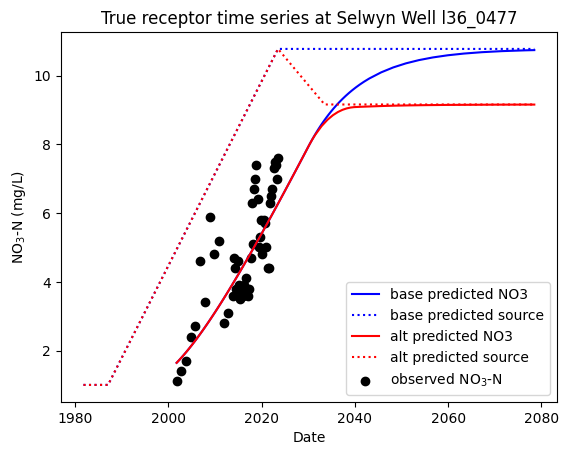

In [22]:
predict_start = (ndata.index.min() - ndata.index.max()).days / 365.25
predict_stop = 55

base_receptor = predict_future_conc_bepm(
    once_and_future_source_conc=base_scenario_source_conc,
    predict_start=predict_start, predict_stop=predict_stop,
    mrt_p1=mrt_p1, frac_p1=frac_p1, f_p1=f_p1, f_p2=f_p2, mrt=mrt, mrt_p2=mrt_p2,
    fill_value=min_conc,
    fill_threshold=0.05, precision=2, pred_step=0.01)

alt_receptor = predict_future_conc_bepm(
    once_and_future_source_conc=alt_scenario_source_conc,
    predict_start=predict_start, predict_stop=predict_stop,
    mrt_p1=mrt_p1, frac_p1=frac_p1, f_p1=f_p1, f_p2=f_p2, mrt=mrt, mrt_p2=mrt_p2,
    fill_value=min_conc, fill_threshold=0.05, precision=2, pred_step=0.01)

# plot the true receptor time series
fig, ax = plt.subplots()
for rec, source, c, lab in zip([base_receptor, alt_receptor], [base_scenario_source_conc, alt_scenario_source_conc],
                               ['blue', 'red', 'gold'], ['base', 'alt', 'gold']):
    x = np.array([ndata.index.max().date() + datetime.timedelta(days=e * 365) for e in rec.index])
    ax.plot(x, rec, color=c, label=f'{lab} predicted NO3')
    idx = source.index >= predict_start - 20
    x = np.array([ndata.index.max().date() + datetime.timedelta(days=e * 365) for e in source.index])
    ax.plot(x[idx], source[idx], color=c, ls=':', label=f'{lab} predicted source')
ax.scatter(ndata.index, ndata['n'], label='observed NO$_{3}$-N', c='k')
ax.set_ylabel('NO$_{3}$-N (mg/L)')
ax.set_xlabel('Date')
ax.set_title('True receptor time series at Selwyn Well l36_0477')
ax.legend()
plt.show()


## Step 5: Estimate the detection power of the well

Looking at the "True" receptor concentration we can see that the proposed reductions will never lead to a decrease in measured receptor concentration. Therefore, a slope detection power (even a multipart Mann Kendall approach) will always yield a power of 0 (i.e., you have a zero percent chance of ever seeing a reduction). In reality there is likely a small chance that a reduction is detected, but this is a type I error - a false positive.  Therefore, if we want to have any hope of checking whether we can detect these reductions we need to use a counterfactual approach.  We will ask "Is the alternative scenario significantly less from the base scenario?"  We can initialise the detection power calculator as follows:

In [23]:
dpc = DetectionPowerCounterFactual(significance_mode='wilcoxon-signed-rank-test',
                                   nsims=1000,
                                   p_value=0.05,
                                   alternative='alt<base')

### 5.1 Set up the sampling frequencies

We are going to assess detection power of:
* sampling at monthly and weekly (12, 52 samples per year)
* sampling for 15, 20, 25, 30, and 50 years
* a sampling delay of 0 and 10 years

In [24]:
nsamples_per_year = [12, 52]
sampling_durations = [15, 20, 25, 30, 50]
sampling_delays = [0, 10]

### Run the detection power

In [25]:
out_data = []

base_sampler = interp1d(base_receptor.index, base_receptor.values)
alt_sampler = interp1d(alt_receptor.index, alt_receptor.values)

for nsamp in nsamples_per_year:
    for dur in sampling_durations:
        for delay in sampling_delays:
            idv = f'{nsamp} _{dur}_{delay}'
            in_base = base_sampler(np.arange(delay, dur + 1 / nsamp, 1 / nsamp))
            in_alt = alt_sampler(np.arange(delay, dur + 1 / nsamp, 1 / nsamp))
            out = dpc.power_calc(
                idv=idv,
                error_base=input_error,
                true_conc_base=in_base,
                true_conc_alt=in_alt,
                error_alt=input_error,
                seed_base=1,  # setting the seeds ensures that the process is reproducible
                seed_alt=2,

                # the following data is passed right to the output pd.Series
                nsamples_per_year=nsamp,
                sampling_duration=dur,
                sampling_delay=delay,
            )
            out_data.append(out)

out_data = pd.DataFrame(out_data).set_index('idv')

print('an example of the output data')
print(out_data.head())



an example of the output data
           power  error_base  error_alt  seed_base  seed_alt python_error  \
idv                                                                         
12 _15_0    19.9    1.057971   1.057971          1         2         None   
12 _15_10   33.1    1.057971   1.057971          1         2         None   
12 _20_0    72.7    1.057971   1.057971          1         2         None   
12 _20_10   94.0    1.057971   1.057971          1         2         None   
12 _25_0    99.6    1.057971   1.057971          1         2         None   

           nsamples_per_year  sampling_duration  sampling_delay  
idv                                                              
12 _15_0                  12                 15               0  
12 _15_10                 12                 15              10  
12 _20_0                  12                 20               0  
12 _20_10                 12                 20              10  
12 _25_0                  12      

### Plot the detection power

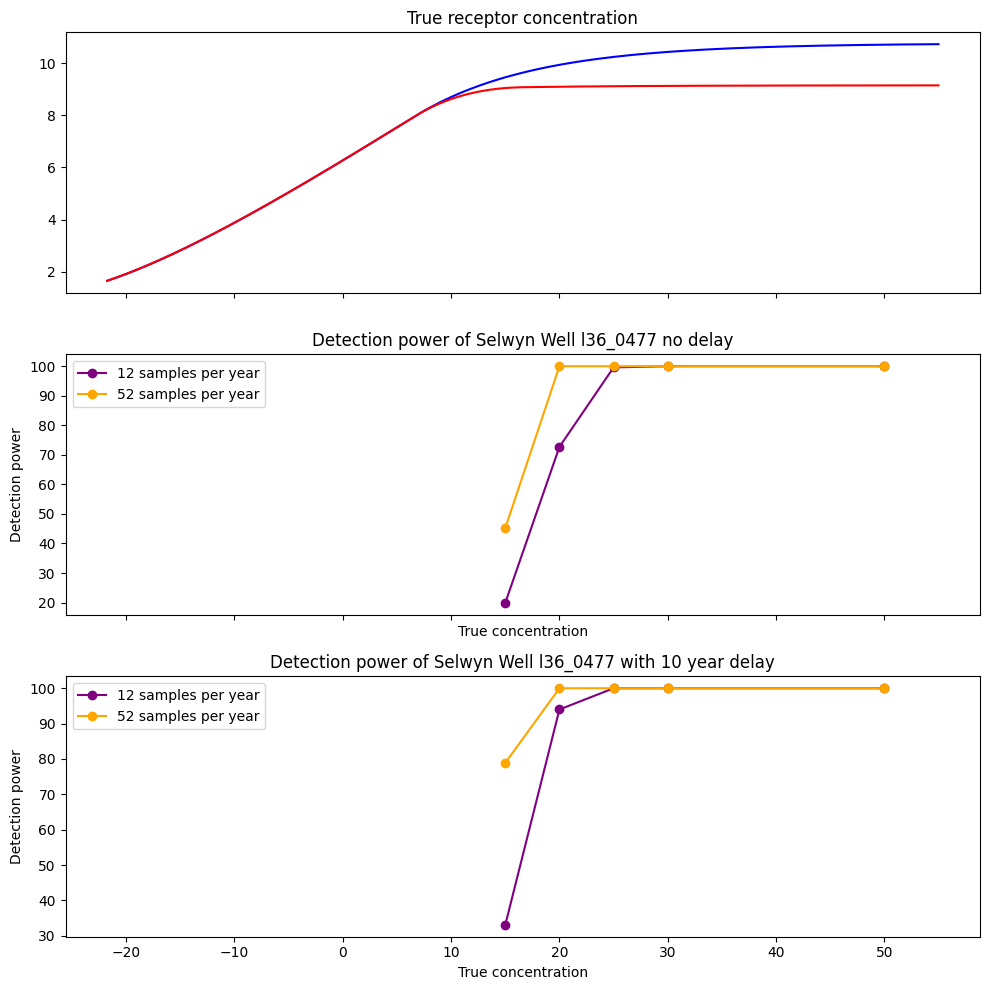

In [26]:
fig, (ax_conc, ax, ax_delay) = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)

ax_conc.set_title('True receptor concentration')
ax_conc.plot(base_receptor.index, base_receptor.values, label='base', c='b')
ax_conc.plot(alt_receptor.index, alt_receptor.values, label='alt', c='r')

ax.set_title('Detection power of Selwyn Well l36_0477 no delay')
ax_delay.set_title('Detection power of Selwyn Well l36_0477 with 10 year delay')
for use_ax, delay in zip([ax, ax_delay], sampling_delays):
    for nsamp, c in zip(nsamples_per_year, ['purple', 'orange']):
        power = []
        duration = []
        for dur in sampling_durations:
            idv = f'{nsamp} _{dur}_{delay}'
            power.append(out_data.loc[idv, 'power'])
            duration.append(dur)
        use_ax.plot(duration, power, label=f'{nsamp} samples per year', color=c, marker='o')
    use_ax.set_ylabel('Detection power')
    use_ax.set_xlabel('True concentration')
    use_ax.legend()
fig.tight_layout()
plt.show()

## Run steps 3-5 with the AutoDetect classes
We can run steps 3-5 with the AutoDetect classes.  These classes will automatically run the steps above and return the detection power for a range of sampling frequencies, durations, and delays. 

In [27]:
auto_dpc = AutoDetectionPowerCounterFactual(significance_mode='wilcoxon-signed-rank-test',
                                            nsims=1000,
                                            p_value=0.05,
                                            alternative='alt<base')

auto_outdata = []
for nsamp in nsamples_per_year:
    for dur in sampling_durations:
        for delay in sampling_delays:
            idv = f'{nsamp} _{dur}_{delay}'
            out = auto_dpc.power_calc(
                idv=idv,
                error_base=input_error,
                mrt_model='binary_exponential_piston_flow',
                samp_years=dur,
                samp_per_year=nsamp,
                implementation_time_alt=10,
                initial_conc=init_conc,
                target_conc_alt=10.77669 * 0.85,
                # 15% reduction from source concentration at time 0 to make it directly comparable to the other method.
                prev_slope=prev_slope,
                max_conc_lim=max_conc,
                min_conc_lim=min_conc,
                mrt=mrt,
                target_conc_base=10.77669,  # source concentration at time 0
                implementation_time_base=10,
                error_alt=None,
                delay_years=delay,

                #
                mrt_p1=mrt_p1,
                frac_p1=frac_p1,
                f_p1=f_p1,
                f_p2=f_p2,
                #
                seed_base=1,
                seed_alt=2,
            )
            auto_outdata.append(out)
            
auto_outdata = pd.DataFrame(auto_outdata).set_index('idv')
if np.allclose(auto_outdata.power, out_data.power, atol=5):
    print('The power values are the same (+/- 5%, rounding errors)')
else:
    raise ValueError('The power values are different')

The power values are the same (+/- 5%, rounding errors)
